<a name="top"> <h1>00. Data Preprocessing</h1> <a>

<p>Análisis de sentimiento: Amazon Reviews<br />
<strong>Trabajo de Fin de Master</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>


<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>


<hr style="border:1px solid gray">

### Estructura

[Introducción](#introduccion) 

[1. Librerias utilizadas y funciones](#librerias) 

[2. Lectura de la base de datos ](#lectura) 

[3. Tokenización de las reviews ](#tokenizacion) 

   - 3.1 Conversión a lowercase
   - 3.2 Borrado de emoticonos
   - 3.3 Borrado de signos de puntuación y saltos de texto
   - 3.4 Tokenización y supresión de stopwords

[4. Wordcloud e histograma](#wordcloud) 


[5. Exportación del DF](#exportacion)

<hr style="border:1px solid gray">

# <a name="introduccion"> Introducción <a>


En este notebook procederemos a realizar un preprocesamiento de datos para análisis de lenguaje natural (NLP) en reviews publicadas en Amazon, en este caso, acerca de tarjetas de regalo. El dataset a analizar, contiene una gran cantidad de reviews junto a variables relacionadas con cada una de ellas, como son el nº de estrellas que el usuario publicó junto a las reviews, el nombre del usuario, si las reviews han sido utiles, si contenian alguna imagen, etc...

El preprocesamiento nos permitirá limpiar los datos y asegurarnos que sean coherentes y tengan un formato adecuado para psoteriormente poder crear un modelo que pueda ser puesto en funcionamiento. Para ello procederemos a utilizar la librería nltk, para poder eliminar stopwords, tokenizar las palabras y la librería r, para eliminar elementos como saltos de texto, emoticonos o links.

Finalmente representaremos gráficamente las palabras más comunes y utilizadas del dataset.

# <a name="librerias"> 1. Librerias utilizadas y funciones <a>


Importamos las librerias a utilizar para el preprocesamiento:

In [15]:
# Import pandas.

import pandas as pd

# Import nltk.

import nltk
nltk.download('punkt')

# Import nltk stopwords.

nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

# Import wordcloud and matplotlib.

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vvict\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vvict\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# <a name="lectura"> 2. Lectura de la base de datos <a>


Procedemos a cargar la base de datos:

In [16]:
# Read json 

reviews_df = pd.read_json("../../data/raw/Gift_Cards.json",  lines=True)

# Display first 5 rows

reviews_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,1,25,False,"12 19, 2008",APV13CM0919JD,B001GXRQW0,{'Gift Amount:': ' 50'},LEH,"Amazon,\nI am shopping for Amazon.com gift car...",Merry Christmas.,1229644800,NaN
1,5,NaN,False,"12 17, 2008",A3G8U1G1V082SN,B001GXRQW0,{'Gift Amount:': ' 50'},Tali,"I got this gift card from a friend, and it was...",Gift card with best selection,1229472000,NaN
2,5,4,False,"12 17, 2008",A11T2Q0EVTUWP,B001GXRQW0,{'Gift Amount:': ' 50'},Z,aren't we going to save trees?! :) People who ...,A convenient and great gift for the environmen...,1229472000,NaN
3,5,NaN,False,"12 17, 2008",A9YKGBH3SV22C,B001GXRQW0,{'Gift Amount:': ' 25'},Giotravels,You can always get someone something from Amaz...,Totally make sense,1229472000,NaN
4,1,NaN,True,"12 17, 2008",A34WZIHVF3OKOL,B001GXRQW0,NaN,King Dad,Why take 50 dollars of good money with no limi...,Give CASH!,1229472000,NaN


### 2.1. Análisis Exploratorio

En primer lugar, observamos la forma del DF. El diccionario de datos se encuentra en `data`.

In [26]:
# Print the shape of the dataframe.

print("The dataframe has {} rows and {} columns.".format(reviews_df.shape[0], reviews_df.shape[1]))

The dataframe has 147194 rows and 12 columns.


In [27]:
# Print the column names and datatypes.

reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147194 entries, 0 to 147193
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         147194 non-null  int64 
 1   vote            6341 non-null    object
 2   verified        147194 non-null  bool  
 3   reviewTime      147194 non-null  object
 4   reviewerID      147194 non-null  object
 5   asin            147194 non-null  object
 6   style           42375 non-null   object
 7   reviewerName    147190 non-null  object
 8   reviewText      147035 non-null  object
 9   summary         147154 non-null  object
 10  unixReviewTime  147194 non-null  int64 
 11  image           406 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 12.5+ MB


In [28]:
# Print the number of null values in each column.

reviews_df.isnull().sum()

overall                0
vote              140853
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             104819
reviewerName           4
reviewText           159
summary               40
unixReviewTime         0
image             146788
dtype: int64

In [29]:
#Convertir los diccionarios a cadenas de texto antes de comprobar duplicados,

reviews_df['reviewText_str'] = reviews_df['reviewText'].astype(str)

# Comprobar filas duplicadas.

num_filas_duplicadas = reviews_df.duplicated(['reviewText_str']).sum()

# Imprimir el número de filas duplicadas.

print("Número de filas duplicadas:", num_filas_duplicadas)

# Eliminar la columna auxiliar.
reviews_df = reviews_df.drop('reviewText_str', axis=1)


# Eliminar filas duplicadas.

reviews_df = reviews_df.drop_duplicates(['reviewText'])

Número de filas duplicadas: 25458


5    102930
4      7392
1      7016
3      2782
2      1616
Name: overall, dtype: int64

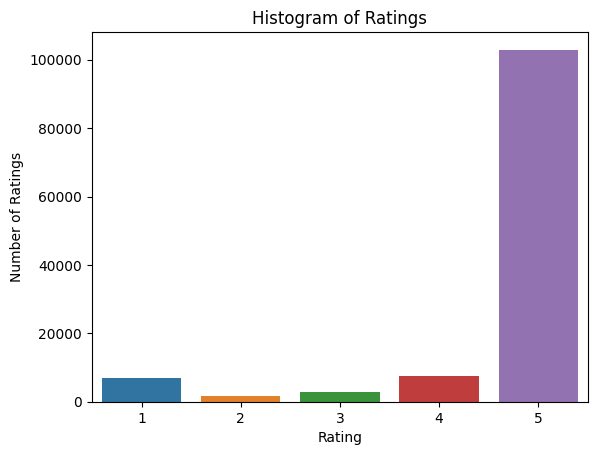

In [30]:
# Create an histogram of the ratings using seaborn.

sns.countplot(x='overall', data=reviews_df)

# Add title and axis names.

plt.title("Histogram of Ratings")

plt.xlabel("Rating")

plt.ylabel("Number of Ratings")

# Print the number of reviews for each rating.

reviews_df['overall'].value_counts()

Una vez importados las reviews, procedemos a quedarnos unicamente con el texto y la puntuación.

In [31]:
# Select the column with text.

review_gifts = reviews_df[['reviewText', 'overall']]

# Display first 5 rows

review_gifts.head()

,reviewText,overall
0,"Amazon,\nI am shopping for Amazon.com gift car...",1
1,"I got this gift card from a friend, and it was...",5
2,aren't we going to save trees?! :) People who ...,5
3,You can always get someone something from Amaz...,5
4,Why take 50 dollars of good money with no limi...,1


# <a name="tokenizacion"> 3. Procesamiento de Lenguaje Natural <a>

La tokenización de palabras es un proceso clave en el análisis de sentimiento de valoración de las reviews. Consiste en dividir un texto en palabras individuales para poder analizarlas de manera más efectiva.

La tokenización permite también la eliminación de palabras irrelevantes o stop words que no aportan información valiosa al análisis de sentimiento, lo que mejora la precisión de los resultados.

### 3.1 Conversión a lowercase


In [32]:
# Convert the text column to lowercase.

review_gifts['reviewText'] = review_gifts['reviewText'].str.lower()

# Display first 5 rows

review_gifts.head()

C:\Users\vvict\AppData\Local\Temp\ipykernel_11336\446667694.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_gifts['reviewText'] = review_gifts['reviewText'].str.lower()


,reviewText,overall
0,"amazon,\ni am shopping for amazon.com gift car...",1
1,"i got this gift card from a friend, and it was...",5
2,aren't we going to save trees?! :) people who ...,5
3,you can always get someone something from amaz...,5
4,why take 50 dollars of good money with no limi...,1


### 3.2 Borrado de emoticonos


In [33]:
# Delete emoticons with text.

review_gifts['reviewText'] = review_gifts['reviewText'].str.replace('[\:\;\=][\-\^]?[\(\)\[\]\{\}\@D\|Pp\$\*\+\#]','')

# Display first 5 rows

review_gifts.head()

C:\Users\vvict\AppData\Local\Temp\ipykernel_11336\897799424.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  review_gifts['reviewText'] = review_gifts['reviewText'].str.replace('[\:\;\=][\-\^]?[\(\)\[\]\{\}\@D\|Pp\$\*\+\#]','')
C:\Users\vvict\AppData\Local\Temp\ipykernel_11336\897799424.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_gifts['reviewText'] = review_gifts['reviewText'].str.replace('[\:\;\=][\-\^]?[\(\)\[\]\{\}\@D\|Pp\$\*\+\#]','')


,reviewText,overall
0,"amazon,\ni am shopping for amazon.com gift car...",1
1,"i got this gift card from a friend, and it was...",5
2,aren't we going to save trees?! people who we...,5
3,you can always get someone something from amaz...,5
4,why take 50 dollars of good money with no limi...,1


### 3.3 Borrado de signos de puntuación y saltos de texto


In [34]:
# Delete punctuation signs.

review_gifts['reviewText'] = review_gifts['reviewText'].str.replace('[^\w\s]','')

# Display first 5 rows

review_gifts.head()

C:\Users\vvict\AppData\Local\Temp\ipykernel_11336\1247172740.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  review_gifts['reviewText'] = review_gifts['reviewText'].str.replace('[^\w\s]','')
C:\Users\vvict\AppData\Local\Temp\ipykernel_11336\1247172740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_gifts['reviewText'] = review_gifts['reviewText'].str.replace('[^\w\s]','')


,reviewText,overall
0,amazon\ni am shopping for amazoncom gift cards...,1
1,i got this gift card from a friend and it was ...,5
2,arent we going to save trees people who were ...,5
3,you can always get someone something from amaz...,5
4,why take 50 dollars of good money with no limi...,1


In [35]:
# Delete /n from text.

review_gifts['reviewText'] = review_gifts['reviewText'].str.replace('\n',' ')

# Display first 5 rows

review_gifts.head()

C:\Users\vvict\AppData\Local\Temp\ipykernel_11336\551323076.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_gifts['reviewText'] = review_gifts['reviewText'].str.replace('\n',' ')


,reviewText,overall
0,amazon i am shopping for amazoncom gift cards ...,1
1,i got this gift card from a friend and it was ...,5
2,arent we going to save trees people who were ...,5
3,you can always get someone something from amaz...,5
4,why take 50 dollars of good money with no limi...,1


### 3.4 Tokenización y supresión de stopwords


In [36]:
# Convert the reviewText column to string.

review_gifts['reviewText'] = review_gifts['reviewText'].astype(str)

# Tokenize the text.

review_gifts['reviewText'] = review_gifts['reviewText'].apply(nltk.word_tokenize)

# Display first 5 rows

review_gifts.head()

C:\Users\vvict\AppData\Local\Temp\ipykernel_11336\4180211318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_gifts['reviewText'] = review_gifts['reviewText'].astype(str)
C:\Users\vvict\AppData\Local\Temp\ipykernel_11336\4180211318.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_gifts['reviewText'] = review_gifts['reviewText'].apply(nltk.word_tokenize)


,reviewText,overall
0,"[amazon, i, am, shopping, for, amazoncom, gift...",1
1,"[i, got, this, gift, card, from, a, friend, an...",5
2,"[arent, we, going, to, save, trees, people, wh...",5
3,"[you, can, always, get, someone, something, fr...",5
4,"[why, take, 50, dollars, of, good, money, with...",1


In [37]:
# Delete the stopwords from text.

stop_words = set(stopwords.words('english'))

review_gifts['reviewText'] = review_gifts['reviewText'].apply(lambda x: [item for item in x if item not in stop_words])

# Display first 5 rows

review_gifts.head()

C:\Users\vvict\AppData\Local\Temp\ipykernel_11336\3866913559.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_gifts['reviewText'] = review_gifts['reviewText'].apply(lambda x: [item for item in x if item not in stop_words])


,reviewText,overall
0,"[amazon, shopping, amazoncom, gift, cards, chr...",1
1,"[got, gift, card, friend, best, site, much, ch...",5
2,"[arent, going, save, trees, people, complainin...",5
3,"[always, get, someone, something, amazon, safe...",5
4,"[take, 50, dollars, good, money, limitations, ...",1


In [38]:
# Convert reviewText column to string with space between words.

review_gifts['reviewText'] = review_gifts['reviewText'].apply(lambda x: ' '.join(x))

# Display first 5 rows

review_gifts.head()

C:\Users\vvict\AppData\Local\Temp\ipykernel_11336\339394713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_gifts['reviewText'] = review_gifts['reviewText'].apply(lambda x: ' '.join(x))


,reviewText,overall
0,amazon shopping amazoncom gift cards christmas...,1
1,got gift card friend best site much choose gre...,5
2,arent going save trees people complaining pape...,5
3,always get someone something amazon safety net...,5
4,take 50 dollars good money limitations turn am...,1


# <a name="wordcloud"> 4. Wordcloud e histograma <a>


Procedemos a analizar en un wordcloud y en un histograma la distribución de las palabras mñas comunes.

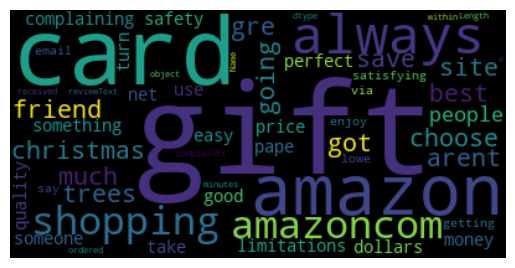

In [39]:
# Create a wordcloud of the first 100 reviews.

wordcloud = WordCloud().generate(str(review_gifts['reviewText']))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis("off")

plt.show()


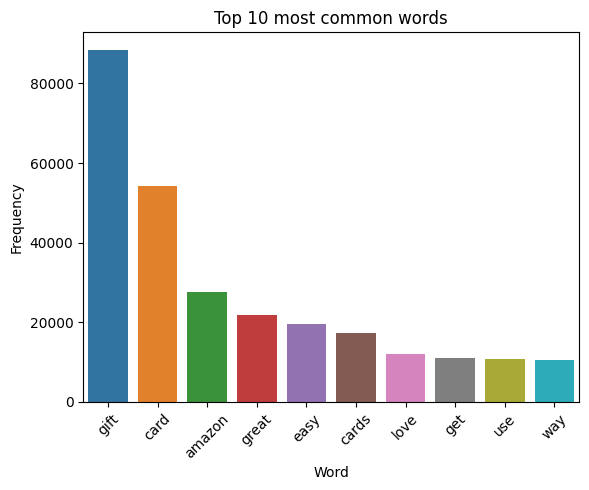

In [41]:
# Histogram of the top 10 most common words.

top_10_words = Counter(" ".join(review_gifts['reviewText']).split()).most_common(10)

top_10_df = pd.DataFrame(top_10_words)

top_10_df.columns=["Word", "Frequency"]

sns.barplot(x="Word", y="Frequency", data=top_10_df)

plt.title("Top 10 most common words")

plt.xlabel("Word")

plt.ylabel("Frequency")

plt.xticks(rotation=45)

plt.show()



# <a name="exportacion"> 5. Exportación del DF <a>


Procedemos a exportar el dataframe ya preprocesado para trabajar con modelos de ML

In [34]:
# Export the dataframe to parquet.

review_gifts.to_parquet("../../data/processed/reviews.parquet")